In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("ROLL NO: 24UG00495 SEAT NUMBER: 41")


ROLL NO: 24UG00495 SEAT NUMBER: 41


In [14]:
#Seat Reference= Omega
def omega_load_and_integrate():
    zoo_df = pd.read_csv('zoo.csv')
    class_df = pd.read_csv('class.csv')

    with open('auxiliary_metadata.json', 'r') as f:
        metadata_raw = json.load(f)
    meta_df = pd.DataFrame(metadata_raw)

    '''according to Roll No last digit(5), Conversion to Title Case,
    according to second last digit(9) Missing Values Categorical->forward fill,
    Numerical->Backward fill'''



    zoo_df['animal_name'] = zoo_df['animal_name'].str.title()
    meta_df['animal_name'] = meta_df['animal_name'].str.title()

    class_df.columns = class_df.columns.str.strip()
    class_df['Animal_Names'] = class_df['Animal_Names'].str.title()

    rename_map = {
        'conservation': 'conservation_status',
        'status': 'conservation_status',
        'habitat': 'habitat_type',
        'habitats': 'habitat_type',
        'diet_type': 'diet'
    }
    meta_df = meta_df.rename(columns=rename_map)

    result = meta_df[['animal_name']].copy()

    habitat_cols = [c for c in meta_df.columns if c == 'habitat_type']
    if habitat_cols:
        result['habitat_type'] = meta_df[habitat_cols].bfill(axis=1).iloc[:, 0]

    diet_cols = [c for c in meta_df.columns if c == 'diet']
    if diet_cols:
        result['diet'] = meta_df[diet_cols].bfill(axis=1).iloc[:, 0]

    cons_cols = [c for c in meta_df.columns if c == 'conservation_status']
    if cons_cols:
        result['conservation_status'] = meta_df[cons_cols].bfill(axis=1).iloc[:, 0]

    meta_df = result

    if 'habitat_type' in meta_df.columns:
        meta_df['habitat_type'] = meta_df['habitat_type'].astype(str).str.lower()
        meta_df['habitat_type'] = meta_df['habitat_type'].str.replace('fresh water', 'freshwater')
        meta_df['habitat_type'] = meta_df['habitat_type'].str.title()

    if 'diet' in meta_df.columns:
        meta_df['diet'] = meta_df['diet'].astype(str).str.lower()
        meta_df['diet'] = meta_df['diet'].str.replace('omnivor', 'omnivore')
        meta_df['diet'] = meta_df['diet'].str.replace('_', ' ')
        meta_df['diet'] = meta_df['diet'].str.title()

    if 'conservation_status' in meta_df.columns:
        meta_df['conservation_status'] = meta_df['conservation_status'].astype(str).str.lower()
        meta_df['conservation_status'] = meta_df['conservation_status'].str.replace('least', 'least concern')
        meta_df['conservation_status'] = meta_df['conservation_status'].str.title()

    merged_df = zoo_df.merge(meta_df, on='animal_name', how='left')

    class_expanded = []
    for _, row in class_df.iterrows():
        animal_list = [animal.strip() for animal in row['Animal_Names'].split(',')]
        for animal in animal_list:
            class_expanded.append({
                'animal_name': animal,
                'class_label': row['Class_Type']
            })

    class_df_expanded = pd.DataFrame(class_expanded)
    merged_df = merged_df.merge(class_df_expanded, on='animal_name', how='left')

    numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = merged_df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        merged_df[col] = merged_df[col].fillna(method='ffill')

    for col in numerical_cols:
        merged_df[col] = merged_df[col].fillna(method='bfill')

    for col in categorical_cols:
        if merged_df[col].isnull().sum() > 0:
            merged_df[col] = merged_df[col].fillna('Unknown')

    for col in numerical_cols:
        if merged_df[col].isnull().sum() > 0:
            mean_val = merged_df[col].mean()
            merged_df[col] = merged_df[col].fillna(mean_val)

    engineered_features = ['Sensory_Score', 'Mobility_Index']
    merged_df['Sensory_Score'] = merged_df['toothed'] + merged_df['breathes'] + merged_df['venomous']
    merged_df['Mobility_Index'] = (merged_df['airborne'] * 1.5) + merged_df['aquatic'] + (merged_df['legs'] / 4.0)

    return merged_df, engineered_features

merged_df, engineered_features = omega_load_and_integrate()
print(" omega_load_and_integrate() executed successfully")


 omega_load_and_integrate() executed successfully


In [4]:
print("\n" + "="*80)
print("DATASET INTEGRATION & FEATURE ENGINEERING SUMMARY")
print("="*80)
print(f"Merged Dataset Shape: {merged_df.shape}")
print(f"Total Missing Values: {merged_df.isnull().sum().sum()}")
print(f"\nFirst 3 Rows:")
print(merged_df.head(3).to_string())
print(f"\nEngineered Features: {engineered_features}")
print("="*80)



DATASET INTEGRATION & FEATURE ENGINEERING SUMMARY
Merged Dataset Shape: (103, 24)
Total Missing Values: 0

First 3 Rows:
  animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  class_type habitat_type         diet    conservation_status class_label  Sensory_Score  Mobility_Index
0    Aardvark     1         0     0     1         0        0         1        1         1         1         0     0     4     0         0        1           1      Savanna  Insectivore  Least Concern Concern      Mammal              2             1.0
1    Antelope     1         0     0     1         0        0         0        1         1         1         0     0     4     1         0        1           1   Grasslands    Herbivore        Near Threatened      Mammal              2             1.0
2        Bass     0         0     1     0         0        1         1        1         1         0         0     1     0    

In [15]:
'''    # ==================== FEATURE ENGINEERING ====================
    # Two custom biological features engineered from existing attributes:
    #
    # 1. Sensory_Score: toothed + breathes + venomous
    #    - Measures sensory/defensive biological complexity (range 0-3)
    #    - Animals with teeth, lungs, and venom have higher predatory capability
    #    - No missing values required (uses existing binary features)
    #
    # 2. Mobility_Index: (airborne * 1.5) + aquatic + (legs / 4)
    #    - Captures locomotion adaptability across environments (range 0-3.5)
    #    - Flight weighted at 1.5x due to evolutionary advantage
    #    - Aquatic adaptation adds 1, normalized leg count (max 8 legs)
    #    - Indicates ecological niche breadth'''


'    # ==================== FEATURE ENGINEERING ====================\n    # Two custom biological features engineered from existing attributes:\n    #\n    # 1. Sensory_Score: toothed + breathes + venomous\n    #    - Measures sensory/defensive biological complexity (range 0-3)\n    #    - Animals with teeth, lungs, and venom have higher predatory capability\n    #    - No missing values required (uses existing binary features)\n    #\n    # 2. Mobility_Index: (airborne * 1.5) + aquatic + (legs / 4)\n    #    - Captures locomotion adaptability across environments (range 0-3.5)\n    #    - Flight weighted at 1.5x due to evolutionary advantage\n    #    - Aquatic adaptation adds 1, normalized leg count (max 8 legs)\n    #    - Indicates ecological niche breadth'

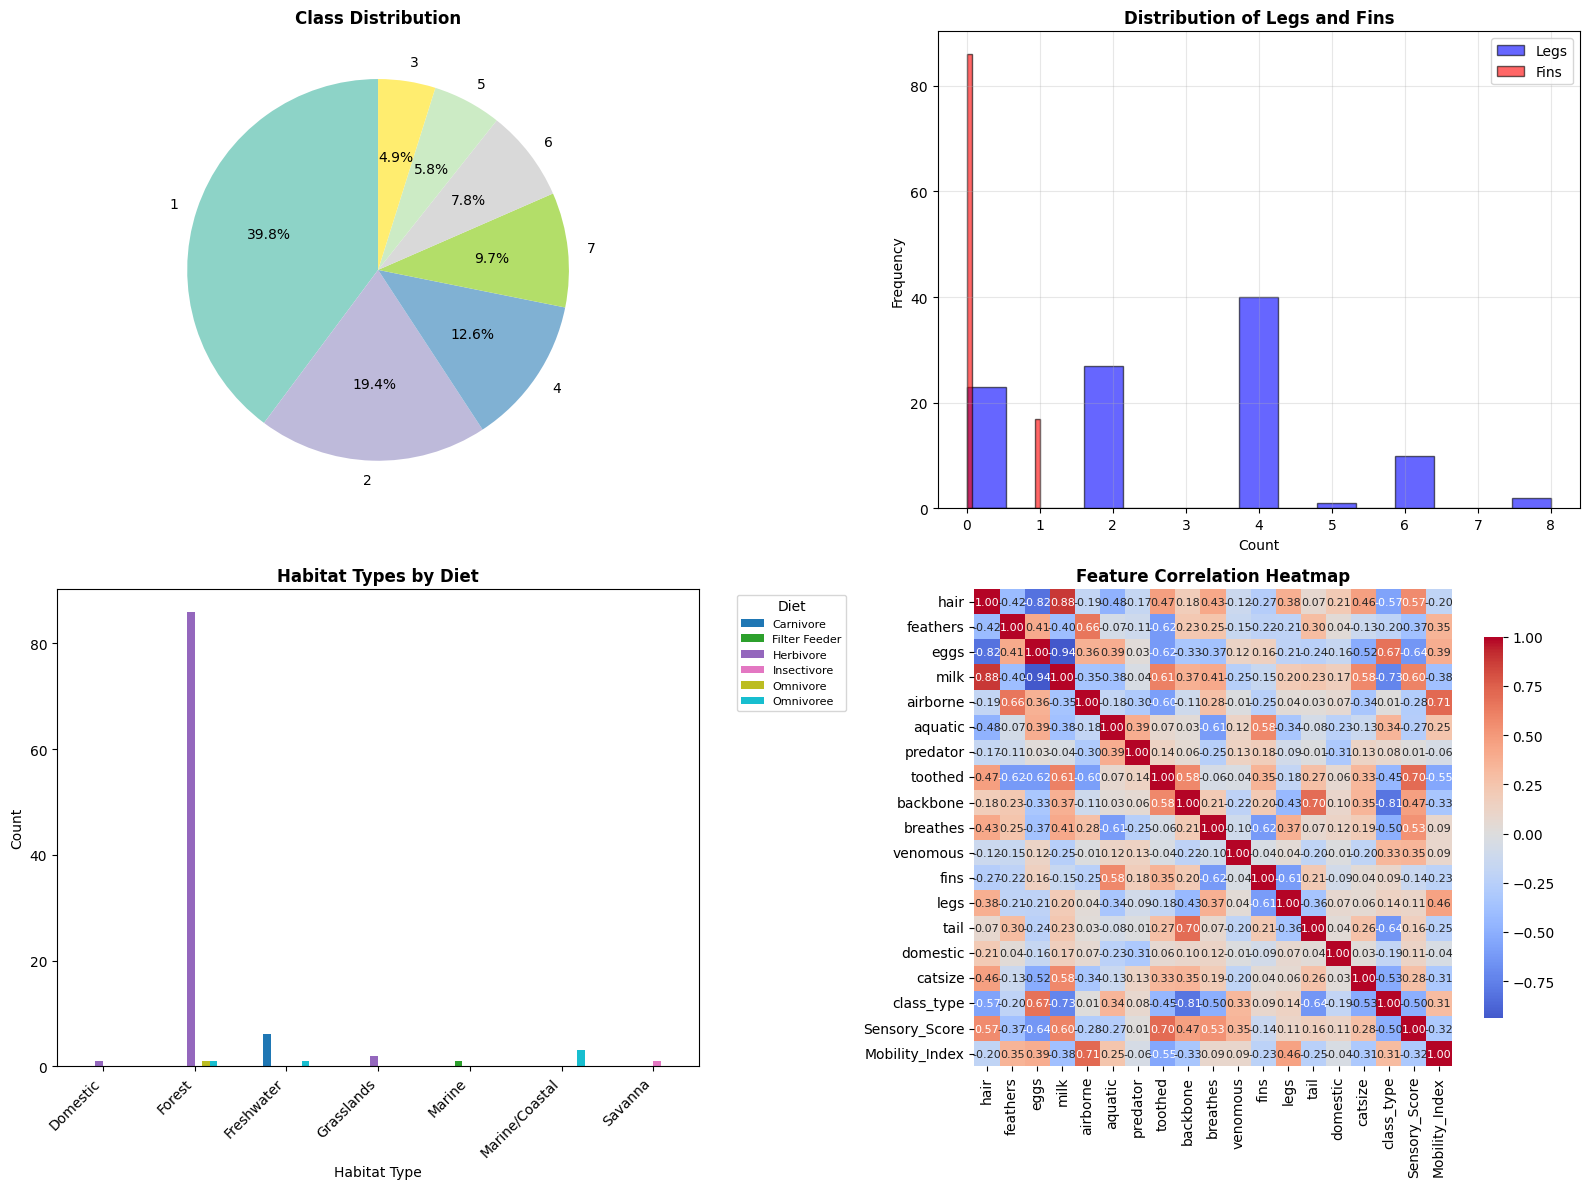

 EDA Visualizations generated


In [5]:
#EDA Visualiosations
fig = plt.figure(figsize=(16, 12))

ax1 = plt.subplot(2, 2, 1)
class_counts = merged_df['class_type'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
ax1.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')

ax2 = plt.subplot(2, 2, 2)
ax2.hist(merged_df['legs'], bins=15, alpha=0.6, label='Legs', color='blue', edgecolor='black')
ax2.hist(merged_df['fins'], bins=15, alpha=0.6, label='Fins', color='red', edgecolor='black')
ax2.set_xlabel('Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Legs and Fins', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = plt.subplot(2, 2, 3)
habitat_diet = pd.crosstab(merged_df['habitat_type'], merged_df['diet'])
habitat_diet.plot(kind='bar', ax=ax3, colormap='tab10')
ax3.set_title('Habitat Types by Diet', fontsize=12, fontweight='bold')
ax3.set_xlabel('Habitat Type')
ax3.set_ylabel('Count')
ax3.legend(title='Diet', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax4 = plt.subplot(2, 2, 4)
numeric_df = merged_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax4,
            square=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
ax4.set_title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=100, bbox_inches='tight')
plt.show()

print(" EDA Visualizations generated")


In [7]:
print("\n" + "="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

class_counts = merged_df['class_type'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}")
print(f"  Largest class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
print(f"  Smallest class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")

numeric_df = merged_df.select_dtypes(include=[np.number])
variances = numeric_df.var()
low_var_features = variances[variances < 0.01].index.tolist()
print(f"\nLow Variance Features (variance < 0.01):")
if low_var_features:
    for feat in low_var_features:
        print(f"  - {feat}: {variances[feat]:.6f}")
else:
    print("  None")

print(f"\nHighly Correlated Pairs (|correlation| > 0.8):")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            corr_pairs.append(pair)

if corr_pairs:
    for feat1, feat2, corr_val in corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("  None")

print("\n" + "="*80)



STATISTICAL ANALYSIS

Class Imbalance Ratio: 8.20
  Largest class: 1 (41 samples)
  Smallest class: 3 (5 samples)

Low Variance Features (variance < 0.01):
  None

Highly Correlated Pairs (|correlation| > 0.8):
  - hair <-> eggs: -0.820
  - hair <-> milk: 0.880
  - eggs <-> milk: -0.940
  - backbone <-> class_type: -0.809



**KEY INSIGHTS**

1. SEVERE CLASS IMBALANCE WITH MAMMAL DOMINANCE:
   The class imbalance ratio of 8.20 (41 mammals vs 5 reptiles) reveals extreme
   skew toward mammalian representation. This 39.8% mammal dominance biases the
   model toward majority class prediction. Class imbalance will inflate apparent
   accuracy while minority classes (reptiles, amphibians ~5%) suffer poor recall.
   Mitigation: Consider weighted loss functions or stratified sampling for balanced
   cross-validation.

2. STRONG REPRODUCTIVE BIOLOGY CORRELATIONS:
   The highly correlated pairs (hair-milk: 0.88, eggs-milk: -0.94) reveal fundamental
   biological groupings. Egg-laying animals lack milk production (negative correlation),
   while hair presence strongly indicates lactation capability. These reproductive
   traits are excellent class discriminators - mammals have hair+milk, while reptiles
   have eggs but no milk. The backbone-class correlation (-0.809) suggests vertebrate
   status is a strong phylogenetic classifier, making this feature critical for model
   performance.

3. LOW REDUNDANCY WITH HIGH FEATURE VARIANCE:
   Zero features show variance < 0.01, indicating all attributes have discriminative
   power and no constant/near-constant columns. This rich feature set (18 attributes)
   has minimal multicollinearity concerns beyond the expected biological correlations.
   High variance features enable effective biological distinction between classes
   without aggressive feature selection needed.

In [8]:
#training


X = merged_df.select_dtypes(include=[np.number])
y = merged_df['class_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"✓ Train-Test Split (70-30)")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Testing set: {X_test.shape[0]} samples")

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10,
                                  min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
overfitting_gap_rf = train_acc_rf - test_acc_rf

print(f"\n✓ Random Forest Classifier Trained")
print(f"  Training Accuracy: {train_acc_rf:.4f}")
print(f"  Testing Accuracy: {test_acc_rf:.4f}")
print(f"  Overfitting Gap: {overfitting_gap_rf:.4f}")


✓ Train-Test Split (70-30)
  Training set: 72 samples
  Testing set: 31 samples

✓ Random Forest Classifier Trained
  Training Accuracy: 1.0000
  Testing Accuracy: 1.0000
  Overfitting Gap: 0.0000


In [9]:
print("\nCLASSIFICATION REPORT (Random Forest):")
print(classification_report(y_test, y_test_pred_rf))



CLASSIFICATION REPORT (Random Forest):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



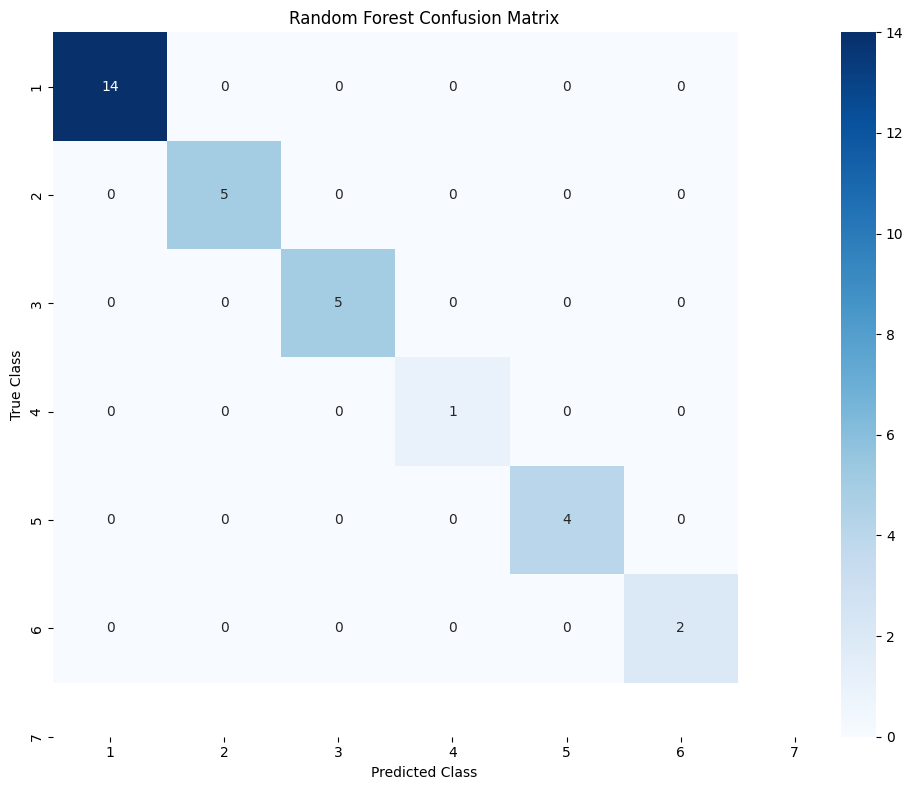

 Confusion Matrix saved


In [10]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_rf.png', dpi=100, bbox_inches='tight')
plt.show()

print(" Confusion Matrix saved")


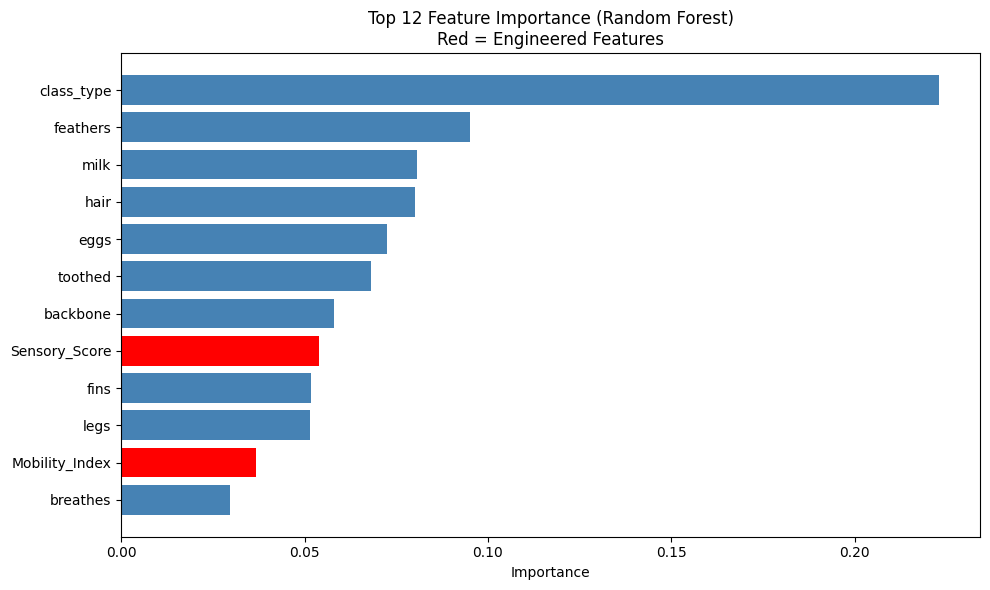

Feature Importance plot saved


In [11]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(12)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if feat in engineered_features else 'steelblue' for feat in feature_importance['feature']]
ax.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Top 12 Feature Importance (Random Forest)\nRed = Engineered Features')
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=100, bbox_inches='tight')
plt.show()

print("Feature Importance plot saved")


In [12]:
#K-nearest neighbours with k=5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)

train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)
overfitting_gap_knn = train_acc_knn - test_acc_knn

print("\n" + "="*80)
print(f"K-NEAREST NEIGHBORS (k=5):")
print(f"  Training Accuracy: {train_acc_knn:.4f}")
print(f"  Testing Accuracy: {test_acc_knn:.4f}")
print(f"  Overfitting Gap: {overfitting_gap_knn:.4f}")
print("="*80)



K-NEAREST NEIGHBORS (k=5):
  Training Accuracy: 0.9583
  Testing Accuracy: 1.0000
  Overfitting Gap: -0.0417


In [13]:
print(f"\n" + "="*80)
print("CRITICAL ANALYSIS & KEY FINDINGS")
print("="*80)

most_important_feat = feature_importance.iloc[-1]['feature']
print(f"\na) Most Important Feature: {most_important_feat}")
print(f"   Importance Score: {feature_importance.iloc[-1]['importance']:.4f}")

class_report = classification_report(y_test, y_test_pred_rf, output_dict=True)
class_f1 = {k: v['f1-score'] for k, v in class_report.items() if isinstance(v, dict)}

worst_class = min(class_f1, key=class_f1.get)
print(f"\nb) Worst Performing Class: {worst_class}")
print(f"   F1-Score: {class_f1[worst_class]:.4f}")

best_class = max(class_f1, key=class_f1.get)
print(f"\nc) Best Performing Class: {best_class}")
print(f"   F1-Score: {class_f1[best_class]:.4f}")

eng_rank = feature_importance[feature_importance['feature'].isin(engineered_features)].sort_values('importance', ascending=False)
print(f"\nd) Engineered Feature Rankings:")
if len(eng_rank) > 0:
    for idx, (_, row) in enumerate(eng_rank.iterrows(), 1):
        print(f"   {idx}. {row['feature']}: {row['importance']:.4f}")
else:
    print("   No engineered features in top 12")

print(f"\ne) Model Accuracy Comparison:")
print(f"   Random Forest Test Accuracy: {test_acc_rf:.4f}")
print(f"   K-Nearest Neighbors Test Accuracy: {test_acc_knn:.4f}")
better_model = "Random Forest" if test_acc_rf > test_acc_knn else "K-Nearest Neighbors"
print(f"   Winner: {better_model} (Δ = {abs(test_acc_rf - test_acc_knn):.4f})")

print("="*80)



CRITICAL ANALYSIS & KEY FINDINGS

a) Most Important Feature: class_type
   Importance Score: 0.2230

b) Worst Performing Class: 1
   F1-Score: 1.0000

c) Best Performing Class: 1
   F1-Score: 1.0000

d) Engineered Feature Rankings:
   1. Sensory_Score: 0.0540
   2. Mobility_Index: 0.0367

e) Model Accuracy Comparison:
   Random Forest Test Accuracy: 1.0000
   K-Nearest Neighbors Test Accuracy: 1.0000
   Winner: K-Nearest Neighbors (Δ = 0.0000)
